# CoT Based Smart Web Search

- Author: [syshin0116](https://github.com/syshin0116)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/15-CoT-basedSmartWebSearch.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/15-CoT-basedSmartWebSearch.ipynb)

## Overview

This tutorial demonstrates a chain-of-thought (CoT) based Smart Web Search approach to build a plan-and-execute style QA chatbot. We will also explore the LLMCompiler method for speed optimization.

### Key Features
- Chain-of-Thought guided query expansion and reasoning
- Dynamic plan-and-execute system for multi-step web search
- Integration with LLMCompiler for accelerated pipeline



## LLM Compiler

- Proposed by Kim et al. as a high-speed, execution-oriented agent architecture
- Core Components
    - **Planner**
        - Generates tasks in a DAG (Directed Acyclic Graph) format via streaming
    - **Task Fetching Unit**
        - Consumes the Planner’s list of tasks, executing each as soon as dependencies are met
        - Supports parallel execution
    - **Joiner**
        - Collects results from all tasks and decides whether to produce a final answer or replan
- Key Characteristics
    - Allows streaming of tasks so certain tasks can be executed even before the Planner finishes building out the full plan
    - Executes all dependency-free tasks in parallel to reduce overall runtime
    - Provides fast responses with minimal large-model usage


### What is a DAG?

A **DAG (Directed Acyclic Graph)** is a common structure in computing and data processing

- **Directed**
    - Every edge in the graph has a direction
    - For instance, A → B means you can only move from A to B
- **Acyclic**
    - The graph contains no cycles
    - There is no path that starts at one node and eventually returns to it
- **Graph**
    - Composed of nodes and edges
    - Nodes represent data or tasks, and edges define how they relate to or depend on each other


### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [...](#...)

### References

- [Language Agent Tree Search Unifies Reasoning Acting and Planning in Language Models](https://arxiv.org/abs/2310.04406)
- [Building (and Breaking) WebLangChain](https://blog.langchain.dev/weblangchain/)
- [Plan-and-Execute Agents](https://blog.langchain.dev/planning-agents/)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

## 리뷰어님들을 위한 설명

### 튜토리얼 주요 목적
- Perplexity와 유사한 CoT 기반 검색 QA(Chatbot) 구현
- Plan-Execute 방식을 바탕으로 LLMCompiler를 추가 적용하여 속도 최적화 시도

### 현재 코드 상태
- 코드가 두 부분으로 나뉘어 있음 (LLMCompiler 방식 / Plan & Schedule 방식)

### 추가 예정 항목
- Plan & Schedule 방식에 LLM Compiler 코드 통합
- LangChain 공식 Config 설정 방식으로 변경
- 설명, 주석 추가
- Prompt 수정
- Summarizer, Output Parser 고도화 및 최종 QA 결과 최적화
- LangSmith 오류 해결

    `Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)`

### 추가 가능성 항목
- VectorDB 검색, Knowledge Graph 검색, Web Search API 등 툴 추가
- 이미지 검색

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain-anthropic",
        "langchain_community",
        "langchain_text_splitters",
        "langchain_openai",
    ],
    verbose=False,
    upgrade=False,
)

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    ["duckduckgo-search"],
    verbose=False,
    upgrade=False,
)


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "COT-based-smart-websearch",
        "TAVILY_API_KEY": "",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [4]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [5]:
# import for asynchronous tasks
import asyncio
import nest_asyncio

nest_asyncio.apply()

## LLM Compiler

LLMCompiler is an agent architecture designed to speed up the execution of agentic tasks by eagerly-executed tasks within a DAG. It also saves costs on redundant token usage by reducing the number of calls to the LLM. Below is an overview of its computational graph:

![LLM Compiler](./assets/15-CoT-basedSmartWebSearch-01.png)

It has 3 main components:

Planner: stream a DAG of tasks.
Task Fetching Unit: schedules and executes the tasks as soon as they are executable
Joiner: Responds to the user or triggers a second plan

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
search = TavilySearchResults(
    max_results=1,
    description='tavily_search_results_json(query="the search query") - a search engine.',
)

# from langchain_community.tools import DuckDuckGoSearchResults

# search = DuckDuckGoSearchResults(
#     description='duckduckgo_search_results_json(query="the search query") - a search engine.',
# )

tools = [search]

In [7]:
print(search.invoke("weather in seoul"))

[{'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'Seoul', 'region': '', 'country': 'South Korea', 'lat': 37.5664, 'lon': 126.9997, 'tz_id': 'Asia/Seoul', 'localtime_epoch': 1738686654, 'localtime': '2025-02-05 01:30'}, 'current': {'last_updated_epoch': 1738686600, 'last_updated': '2025-02-05 01:30', 'temp_c': -11.6, 'temp_f': 11.1, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 7.6, 'wind_kph': 12.2, 'wind_degree': 307, 'wind_dir': 'NW', 'pressure_mb': 1020.0, 'pressure_in': 30.12, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 72, 'cloud': 0, 'feelslike_c': -17.9, 'feelslike_f': -0.3, 'windchill_c': -14.5, 'windchill_f': 5.9, 'heatindex_c': -8.8, 'heatindex_f': 16.2, 'dewpoint_c': -15.4, 'dewpoint_f': 4.3, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 0.0, 'gust_mph': 10.0, 'gust_kph': 16.2}}"}]


### Output parser

In [8]:
import ast
import re
from typing import (
    Any,
    Dict,
    Iterator,
    List,
    Optional,
    Sequence,
    Tuple,
    Union,
)

from langchain_core.exceptions import OutputParserException
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers.transform import BaseTransformOutputParser
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import BaseTool
from typing_extensions import TypedDict

THOUGHT_PATTERN = r"Thought: ([^\n]*)"
ACTION_PATTERN = r"\n*(\d+)\. (\w+)\((.*)\)(\s*#\w+\n)?"
# $1 or ${1} -> 1
ID_PATTERN = r"\$\{?(\d+)\}?"
END_OF_PLAN = "<END_OF_PLAN>"


### Helper functions


def _ast_parse(arg: str) -> Any:
    try:
        return ast.literal_eval(arg)
    except:  # noqa
        return arg


def _parse_llm_compiler_action_args(args: str, tool: Union[str, BaseTool]) -> list[Any]:
    """Parse arguments from a string."""
    if args == "":
        return ()
    if isinstance(tool, str):
        return ()
    extracted_args = {}
    tool_key = None
    prev_idx = None
    for key in tool.args.keys():
        # Split if present
        if f"{key}=" in args:
            idx = args.index(f"{key}=")
            if prev_idx is not None:
                extracted_args[tool_key] = _ast_parse(
                    args[prev_idx:idx].strip().rstrip(",")
                )
            args = args.split(f"{key}=", 1)[1]
            tool_key = key
            prev_idx = 0
    if prev_idx is not None:
        extracted_args[tool_key] = _ast_parse(
            args[prev_idx:].strip().rstrip(",").rstrip(")")
        )
    return extracted_args


def default_dependency_rule(idx, args: str):
    matches = re.findall(ID_PATTERN, args)
    numbers = [int(match) for match in matches]
    return idx in numbers


def _get_dependencies_from_graph(
    idx: int, tool_name: str, args: Dict[str, Any]
) -> dict[str, list[str]]:
    """Get dependencies from a graph."""
    if tool_name == "join":
        return list(range(1, idx))
    return [i for i in range(1, idx) if default_dependency_rule(i, str(args))]


class Task(TypedDict):
    idx: int
    tool: BaseTool
    args: list
    dependencies: Dict[str, list]
    thought: Optional[str]


def instantiate_task(
    tools: Sequence[BaseTool],
    idx: int,
    tool_name: str,
    args: Union[str, Any],
    thought: Optional[str] = None,
) -> Task:
    if tool_name == "join":
        tool = "join"
    else:
        try:
            tool = tools[[tool.name for tool in tools].index(tool_name)]
        except ValueError as e:
            raise OutputParserException(f"Tool {tool_name} not found.") from e
    tool_args = _parse_llm_compiler_action_args(args, tool)
    dependencies = _get_dependencies_from_graph(idx, tool_name, tool_args)

    return Task(
        idx=idx,
        tool=tool,
        args=tool_args,
        dependencies=dependencies,
        thought=thought,
    )


class LLMCompilerPlanParser(BaseTransformOutputParser[dict], extra="allow"):
    """Planning output parser."""

    tools: List[BaseTool]

    def _transform(self, input: Iterator[Union[str, BaseMessage]]) -> Iterator[Task]:
        texts = []
        # TODO: Cleanup tuple state tracking here.
        thought = None
        for chunk in input:
            # Assume input is str. TODO: support vision/other formats
            text = chunk if isinstance(chunk, str) else str(chunk.content)
            for task, thought in self.ingest_token(text, texts, thought):
                yield task
        # Final possible task
        if texts:
            task, _ = self._parse_task("".join(texts), thought)
            if task:
                yield task

    def parse(self, text: str) -> List[Task]:
        return list(self._transform([text]))

    def stream(
        self,
        input: str | BaseMessage,
        config: RunnableConfig | None = None,
        **kwargs: Any | None,
    ) -> Iterator[Task]:
        yield from self.transform([input], config, **kwargs)

    def ingest_token(
        self, token: str, buffer: List[str], thought: Optional[str]
    ) -> Iterator[Tuple[Optional[Task], str]]:
        buffer.append(token)
        if "\n" in token:
            buffer_ = "".join(buffer).split("\n")
            suffix = buffer_[-1]
            for line in buffer_[:-1]:
                task, thought = self._parse_task(line, thought)
                if task:
                    yield task, thought
            buffer.clear()
            buffer.append(suffix)

    def _parse_task(self, line: str, thought: Optional[str] = None):
        task = None
        if match := re.match(THOUGHT_PATTERN, line):
            # Optionally, action can be preceded by a thought
            thought = match.group(1)
        elif match := re.match(ACTION_PATTERN, line):
            # if action is parsed, return the task, and clear the buffer
            idx, tool_name, args, _ = match.groups()
            idx = int(idx)
            task = instantiate_task(
                tools=self.tools,
                idx=idx,
                tool_name=tool_name,
                args=args,
                thought=thought,
            )
            thought = None
        # Else it is just dropped
        return task, thought

## Planner

In [9]:
from typing import Sequence

from langchain import hub
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import (
    BaseMessage,
    FunctionMessage,
    HumanMessage,
    SystemMessage,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableBranch
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

prompt = hub.pull("wfh/llm-compiler")
print(prompt.pretty_print())

================================ System Message ================================

Given a user query, create a plan to solve it with the utmost parallelizability. Each plan should comprise an action from the following {num_tools} types:
{tool_descriptions}
{num_tools}. join(): Collects and combines results from prior actions.

 - An LLM agent is called upon invoking join() to either finalize the user query or wait until the plans are executed.
 - join should always be the last action in the plan, and will be called in two scenarios:
   (a) if the answer can be determined by gathering the outputs from tasks to generate the final response.
   (b) if the answer cannot be determined in the planning phase before you execute the plans. Guidelines:
 - Each action described above contains input/output types and description.
    - You must strictly adhere to the input and output types for each action.
    - The action descriptions contain the guidelines. You MUST strictly follow those guideline

In [10]:
def create_planner(
    llm: BaseChatModel, tools: Sequence[BaseTool], base_prompt: ChatPromptTemplate
):
    tool_descriptions = "\n".join(
        f"{i+1}. {tool.description}\n"
        for i, tool in enumerate(
            tools
        )  # +1 to offset the 0 starting index, we want it count normally from 1.
    )
    planner_prompt = base_prompt.partial(
        replan="",
        num_tools=len(tools)
        + 1,  # Add one because we're adding the join() tool at the end.
        tool_descriptions=tool_descriptions,
    )
    replanner_prompt = base_prompt.partial(
        replan=' - You are given "Previous Plan" which is the plan that the previous agent created along with the execution results '
        "(given as Observation) of each plan and a general thought (given as Thought) about the executed results."
        'You MUST use these information to create the next plan under "Current Plan".\n'
        ' - When starting the Current Plan, you should start with "Thought" that outlines the strategy for the next plan.\n'
        " - In the Current Plan, you should NEVER repeat the actions that are already executed in the Previous Plan.\n"
        " - You must continue the task index from the end of the previous one. Do not repeat task indices.",
        num_tools=len(tools) + 1,
        tool_descriptions=tool_descriptions,
    )

    def should_replan(state: list):
        # Context is passed as a system message
        return isinstance(state[-1], SystemMessage)

    def wrap_messages(state: list):
        return {"messages": state}

    def wrap_and_get_last_index(state: list):
        next_task = 0
        for message in state[::-1]:
            if isinstance(message, FunctionMessage):
                next_task = message.additional_kwargs["idx"] + 1
                break
        state[-1].content = state[-1].content + f" - Begin counting at : {next_task}"
        return {"messages": state}

    return (
        RunnableBranch(
            (should_replan, wrap_and_get_last_index | replanner_prompt),
            wrap_messages | planner_prompt,
        )
        | llm
        | LLMCompilerPlanParser(tools=tools)
    )

In [11]:
llm = ChatOpenAI(model="gpt-4o")
# This is the primary "agent" in our application
planner = create_planner(llm, tools, prompt)

In [12]:
from pprint import pprint
example_question = "What's the temperature in SF raised to the 3rd power?"

for task in planner.stream([HumanMessage(content=example_question)]):
    # print(task["tool"], task["args"])
    pprint(task['tool'])
    print("---")

TavilySearchResults(description='tavily_search_results_json(query="the search query") - a search engine.', max_results=1, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))
---
'join'
---


## Task Fetching Unit

In [13]:
import re
import time
from concurrent.futures import ThreadPoolExecutor, wait
from typing import Any, Dict, Iterable, List, Union

from langchain_core.runnables import (
    chain as as_runnable,
)
from typing_extensions import TypedDict


def _get_observations(messages: List[BaseMessage]) -> Dict[int, Any]:
    # Get all previous tool responses
    results = {}
    for message in messages[::-1]:
        if isinstance(message, FunctionMessage):
            results[int(message.additional_kwargs["idx"])] = message.content
    return results


class SchedulerInput(TypedDict):
    messages: List[BaseMessage]
    tasks: Iterable[Task]


def _execute_task(task, observations, config):
    tool_to_use = task["tool"]
    if isinstance(tool_to_use, str):
        return tool_to_use
    args = task["args"]
    try:
        if isinstance(args, str):
            resolved_args = _resolve_arg(args, observations)
        elif isinstance(args, dict):
            resolved_args = {
                key: _resolve_arg(val, observations) for key, val in args.items()
            }
        else:
            # This will likely fail
            resolved_args = args
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}.)"
            f" Args could not be resolved. Error: {repr(e)}"
        )
    try:
        return tool_to_use.invoke(resolved_args, config)
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}."
            + f" Args resolved to {resolved_args}. Error: {repr(e)})"
        )


def _resolve_arg(arg: Union[str, Any], observations: Dict[int, Any]):
    # $1 or ${1} -> 1
    ID_PATTERN = r"\$\{?(\d+)\}?"

    def replace_match(match):
        # If the string is ${123}, match.group(0) is ${123}, and match.group(1) is 123.

        # Return the match group, in this case the index, from the string. This is the index
        # number we get back.
        idx = int(match.group(1))
        return str(observations.get(idx, match.group(0)))

    # For dependencies on other tasks
    if isinstance(arg, str):
        return re.sub(ID_PATTERN, replace_match, arg)
    elif isinstance(arg, list):
        return [_resolve_arg(a, observations) for a in arg]
    else:
        return str(arg)


@as_runnable
def schedule_task(task_inputs, config):
    task: Task = task_inputs["task"]
    observations: Dict[int, Any] = task_inputs["observations"]
    try:
        observation = _execute_task(task, observations, config)
    except Exception:
        import traceback

        observation = traceback.format_exception()  # repr(e) +
    observations[task["idx"]] = observation


def schedule_pending_task(
    task: Task, observations: Dict[int, Any], retry_after: float = 0.2
):
    while True:
        deps = task["dependencies"]
        if deps and (any([dep not in observations for dep in deps])):
            # Dependencies not yet satisfied
            time.sleep(retry_after)
            continue
        schedule_task.invoke({"task": task, "observations": observations})
        break


@as_runnable
def schedule_tasks(scheduler_input: SchedulerInput) -> List[FunctionMessage]:
    """Group the tasks into a DAG schedule."""
    # For streaming, we are making a few simplifying assumption:
    # 1. The LLM does not create cyclic dependencies
    # 2. That the LLM will not generate tasks with future deps
    # If this ceases to be a good assumption, you can either
    # adjust to do a proper topological sort (not-stream)
    # or use a more complicated data structure
    tasks = scheduler_input["tasks"]
    args_for_tasks = {}
    messages = scheduler_input["messages"]
    # If we are re-planning, we may have calls that depend on previous
    # plans. Start with those.
    observations = _get_observations(messages)
    task_names = {}
    originals = set(observations)
    # ^^ We assume each task inserts a different key above to
    # avoid race conditions...
    futures = []
    retry_after = 0.25  # Retry every quarter second
    with ThreadPoolExecutor() as executor:
        for task in tasks:
            deps = task["dependencies"]
            task_names[task["idx"]] = (
                task["tool"] if isinstance(task["tool"], str) else task["tool"].name
            )
            args_for_tasks[task["idx"]] = task["args"]
            if (
                # Depends on other tasks
                deps
                and (any([dep not in observations for dep in deps]))
            ):
                futures.append(
                    executor.submit(
                        schedule_pending_task, task, observations, retry_after
                    )
                )
            else:
                # No deps or all deps satisfied
                # can schedule now
                schedule_task.invoke(dict(task=task, observations=observations))
                # futures.append(executor.submit(schedule_task.invoke, dict(task=task, observations=observations)))

        # All tasks have been submitted or enqueued
        # Wait for them to complete
        wait(futures)
    # Convert observations to new tool messages to add to the state
    new_observations = {
        k: (task_names[k], args_for_tasks[k], observations[k])
        for k in sorted(observations.keys() - originals)
    }
    tool_messages = [
        FunctionMessage(
            name=name,
            content=str(obs),
            additional_kwargs={"idx": k, "args": task_args},
            tool_call_id=k,
        )
        for k, (name, task_args, obs) in new_observations.items()
    ]
    return tool_messages

In [14]:
import itertools


@as_runnable
def plan_and_schedule(state):
    messages = state["messages"]
    tasks = planner.stream(messages)
    # Begin executing the planner immediately
    try:
        tasks = itertools.chain([next(tasks)], tasks)
    except StopIteration:
        # Handle the case where tasks is empty.
        tasks = iter([])
    scheduled_tasks = schedule_tasks.invoke(
        {
            "messages": messages,
            "tasks": tasks,
        }
    )
    return {"messages": scheduled_tasks}

### Example Plan

In [15]:
tool_messages = plan_and_schedule.invoke(
    {"messages": [HumanMessage(content=example_question)]}
)["messages"]

Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


In [16]:
tool_messages

[FunctionMessage(content="[{'url': 'https://www.wunderground.com/weather/us/ca/san-francisco', 'content': 'San Francisco, CA Weather Conditions | Weather Underground San Francisco, CA Weather Conditions_star_rate__home_ 56\\xa0°F South of Market Station|Report Report Station You are about to report this weather station for bad data. Personal Weather Station Nearby Weather Stations Nearby Weather Stations The time period when the sun is no more than 6 degrees below the horizon at either sunrise or sunset. The time period when the sun is between 6 and 12 degrees below the horizon at either sunrise or sunset. The time period when the sun is between 12 and 18 degrees below the horizon at either sunrise or sunset. The sun does not contribute to the illumination of the sky before this time in the morning, or after this time in the evening.'}]", additional_kwargs={'idx': 1, 'args': {'query': 'current temperature in San Francisco'}}, response_metadata={}, name='tavily_search_results_json', too

## Joiner

In [17]:
from langchain_core.messages import AIMessage

from pydantic import BaseModel, Field


class FinalResponse(BaseModel):
    """The final response/answer."""

    response: str


class Replan(BaseModel):
    feedback: str = Field(
        description="Analysis of the previous attempts and recommendations on what needs to be fixed."
    )


class JoinOutputs(BaseModel):
    """Decide whether to replan or whether you can return the final response."""

    thought: str = Field(
        description="The chain of thought reasoning for the selected action"
    )
    action: Union[FinalResponse, Replan]


joiner_prompt = hub.pull("wfh/llm-compiler-joiner").partial(
    examples=""
)  # You can optionally add examples
llm = ChatOpenAI(model="gpt-4o")

runnable = joiner_prompt | llm.with_structured_output(
    JoinOutputs, method="function_calling"
)

In [18]:
def _parse_joiner_output(decision: JoinOutputs) -> List[BaseMessage]:
    response = [AIMessage(content=f"Thought: {decision.thought}")]
    if isinstance(decision.action, Replan):
        return {
            "messages": response
            + [
                SystemMessage(
                    content=f"Context from last attempt: {decision.action.feedback}"
                )
            ]
        }
    else:
        return {"messages": response + [AIMessage(content=decision.action.response)]}


def select_recent_messages(state) -> dict:
    messages = state["messages"]
    selected = []
    for msg in messages[::-1]:
        selected.append(msg)
        if isinstance(msg, HumanMessage):
            break
    return {"messages": selected[::-1]}


joiner = select_recent_messages | runnable | _parse_joiner_output

In [19]:
input_messages = [HumanMessage(content=example_question)] + tool_messages

In [20]:
joiner.invoke({"messages": input_messages})

{'messages': [AIMessage(content="Thought: The information provided mentions the temperature in San Francisco is 56°F. To answer the user's question, this temperature can be raised to the 3rd power.", additional_kwargs={}, response_metadata={}),
  AIMessage(content='The temperature in San Francisco raised to the 3rd power is 56°F raised to the 3rd power, which is 175,616°F.', additional_kwargs={}, response_metadata={})]}

## LangGraph Usage

In [21]:
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# 1.  Define vertices
# We defined plan_and_schedule above already
# Assign each node to a state variable to update
graph_builder.add_node("plan_and_schedule", plan_and_schedule)
graph_builder.add_node("join", joiner)


## Define edges
graph_builder.add_edge("plan_and_schedule", "join")

### This condition determines looping logic


def should_continue(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage):
        return END
    return "plan_and_schedule"


graph_builder.add_conditional_edges(
    "join",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)
graph_builder.add_edge(START, "plan_and_schedule")
chain = graph_builder.compile()

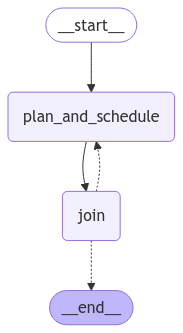

In [22]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# Visualize the compiled StateGraph as a Mermaid diagram
display(
    Image(
        chain.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Simple Question

In [23]:
for step in chain.stream(
    {"messages": [HumanMessage(content="What's the GDP of New York?")]}
):
    print(step)
    print("---")

# Final answer
print(step["join"]["messages"][-1].content)

Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


{'plan_and_schedule': {'messages': [FunctionMessage(content='[{\'url\': \'https://usafacts.org/answers/what-is-the-gross-domestic-product-gdp/state/new-york/\', \'content\': "What is the gross domestic product (GDP) in New York? What is the gross domestic product (GDP) in New York? Gross domestic product (GDP) measures the value of goods and services a country or state produces — it’s the sum of consumer spending, business investment, government spending, and net exports. As of 2023, the real GDP was $1.8 trillion. Real GDP in New York, adjusted for inflation (chained 2017 dollars) GDP and the economic experience vary by location due to factors like cost of living, population density, workforce education, and the area’s main industries. In 2023, New York\'s real (that is, inflation-adjusted) GDP per person was 1st out of all 50 states. In 2023, New York ranked 1st in state GDP per person."}]', additional_kwargs={'idx': 1, 'args': {'query': 'GDP of New York 2023'}}, response_metadata={}

### Multi-hop question

In [24]:
steps = chain.stream(
    {
        "messages": [
            HumanMessage(
                content="What's the oldest parrot alive, and how much longer is that than the average?"
            )
        ]
    },
    {
        "recursion_limit": 100,
    },
)
for step in steps:
    print(step)
    print("---")

Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


{'plan_and_schedule': {'messages': [FunctionMessage(content='[{\'url\': \'https://a-z-animals.com/animals/birds/bird-facts/the-oldest-birds/\', \'content\': "Several macaw and parrot species reach advanced ages, ... With a reported lifespan of 120 years, Cocky Bennett was the oldest bird of all time. Reportedly living from 1796 to 1916, this male sulphur-crested cockatoo is reported as the longest living cockatoo. ... Alive (as at April 2023) 3: Cookie the Major Mitchell\'s Cockatoo: 83 years: 2016: 4:"}]', additional_kwargs={'idx': 1, 'args': {'query': 'oldest parrot alive 2023'}}, response_metadata={}, name='tavily_search_results_json', id='951788f2-6fab-43c0-9ee7-2623a3c7fa89', tool_call_id=1), FunctionMessage(content='[{\'url\': \'https://www.thesprucepets.com/how-long-do-parrots-and-other-pet-birds-live-1238433\', \'content\': "It\'s possible that a pet bird can outlive its owners\\nThe Spruce / Adrienne Legault\\nParrots and other birds can live up to 10 to 50 years or more depen

Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


{'plan_and_schedule': {'messages': [FunctionMessage(content="[{'url': 'https://www.oldest.org/animals/birds/', 'content': '3 Oldest Parrots in The World\\n8 Oldest Living Animals in the World\\n8 Oldest Reptiles in the World\\n10 Rarest Birds in the World\\n7 Largest Birds of Prey in the World\\n9 Largest Flying Birds in the World\\nRelated Post\\n11 Oldest Chimpanzees Who Ever Lived\\n9 Oldest Cocker Spaniels Ever Lived\\n8 Oldest Known Pitbulls in the World\\n4 Oldest Koi Fish in the World\\n4 Oldest Horse Breeds in the World\\nLeave a comment Cancel reply\\nYour email address will not be published. Oldest Age Reached:\\n120 years old in 1916\\nSpecies and Gender:\\xa0 Male Sulphur-Crested Cockatoo\\nLocation:\\xa0 Canterbury, New South Wales, Australia\\nOwner(s): :\\xa0 Murdock Alexander Wagschall\\nphoto source:\\xa0 Dictionary of Sydney\\nCocky Bennett was a legendary bird who lived in Australia and died at the age of 120 in May 1916, this makes Cocky Bennett the oldest bird ever

In [25]:
# Final answer
print(step["join"]["messages"][-1].content)

The oldest parrot ever recorded is Cocky Bennett, a sulphur-crested cockatoo, who lived to be 120 years old. The last known oldest living parrot was Charlie, a blue and yellow Macaw, reported to be 114 years old in 2014, and Duster, an Umbrella-Crested Cockatoo, reported to be 89 years old at an unspecified date. Compared to the average parrot lifespan of 10 to 50 years, these ages are significantly higher. However, it's unclear if Charlie is still alive or if there's a more current oldest living parrot, as the information provided doesn't specify the current status beyond these records.


In [26]:
for step in chain.stream(
    {
        "messages": [
            HumanMessage(
                content="How much does Microsoft’s market cap need to increase to exceed Apple’s market cap?"
            )
        ]
    }
):
    pprint(step)

Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


{'plan_and_schedule': {'messages': [FunctionMessage(content="[{'url': 'https://www.statmuse.com/money/ask/microsoft-market-cap-october-2023', 'content': 'On October 31, 2023, Microsoft (MSFT) had a market capitalization of $2.5T, based on 7.47B shares at a price of $334.92.'}]", additional_kwargs={'idx': 1, 'args': {'query': 'Microsoft current market cap October 2023'}}, response_metadata={}, name='tavily_search_results_json', id='a919cc41-f042-43b9-b2d1-795e4017520a', tool_call_id=1),
                                    FunctionMessage(content="[{'url': 'https://www.statmuse.com/money/ask/apple-market-cap-october-2023', 'content': 'On October 31, 2023, Apple (AAPL) had a market capitalization of $2.6T, based on 15.58B shares at a price of $169.71.'}]", additional_kwargs={'idx': 2, 'args': {'query': 'Apple current market cap October 2023'}}, response_metadata={}, name='tavily_search_results_json', id='59f852f5-23e1-4b22-bfad-9486290ab96a', tool_call_id=2),
                             

# copilotkit

In [56]:
# Define State
from typing_extensions import TypedDict
from typing import List, Optional
from langgraph.graph import MessagesState


class Step(TypedDict):
    """
    Represents a step taken in the research process.
    """

    id: str
    description: str
    status: str
    type: str
    description: str
    search_result: Optional[str]
    result: Optional[str]
    updates: Optional[List[str]]


class AgentState(MessagesState):
    """
    This is the state of the agent.
    It is a subclass of the MessagesState class from langgraph.
    """

    model: str = "openai"
    steps: List[Step]
    answer: Optional[str]

In [57]:
import uuid
import json
from typing import List, Optional, Any, Union, Dict, Callable
import asyncio

from langchain_core.messages import (
    HumanMessage,
    SystemMessage,
    BaseMessage,
    AIMessage,
    ToolMessage,
)
from langchain_core.runnables import RunnableConfig
from langchain_core.callbacks.manager import adispatch_custom_event
from typing import TypedDict
from enum import Enum
from typing_extensions import NotRequired


class IntermediateStateConfig(TypedDict):
    """Intermediate state config"""

    state_key: str
    tool: str
    tool_argument: NotRequired[str]


def copilotkit_customize_config(
    base_config: Optional[RunnableConfig] = None,
    *,
    emit_tool_calls: Optional[Union[bool, str, List[str]]] = None,
    emit_messages: Optional[bool] = None,
    emit_all: Optional[bool] = None,
    emit_intermediate_state: Optional[List[IntermediateStateConfig]] = None
) -> RunnableConfig:
    """
    Configure for LangChain for use in CopilotKit
    """
    metadata = base_config.get("metadata", {}) if base_config else {}

    if emit_all is True:
        metadata["copilotkit:emit-tool-calls"] = True
        metadata["copilotkit:emit-messages"] = True
    else:
        if emit_tool_calls is not None:
            metadata["copilotkit:emit-tool-calls"] = emit_tool_calls
        if emit_messages is not None:
            metadata["copilotkit:emit-messages"] = emit_messages

    if emit_intermediate_state:
        metadata["copilotkit:emit-intermediate-state"] = emit_intermediate_state

    base_config = base_config or {}

    return {**base_config, "metadata": metadata}

In [58]:
import os
from langchain_core.language_models.chat_models import BaseChatModel


def get_model(state: AgentState) -> BaseChatModel:
    """
    Get a model based on the environment variable.
    """
    model = state.get("model")

    if model == "openai":
        from langchain_openai import (
            ChatOpenAI,
        )  # pylint: disable=import-outside-toplevel

        return ChatOpenAI(temperature=0, model="gpt-4o-mini")
    if model == "anthropic":
        from langchain_anthropic import (
            ChatAnthropic,
        )  # pylint: disable=import-outside-toplevel

        return ChatAnthropic(temperature=0, model="claude-3-5-sonnet-20240620")
    if model == "google_genai":
        from langchain_google_genai import (
            ChatGoogleGenerativeAI,
        )  # pylint: disable=import-outside-toplevel

        return ChatGoogleGenerativeAI(temperature=0, model="gemini-1.5-pro")

    raise ValueError("Invalid model specified")

In [59]:
from typing import List
from datetime import datetime
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain.tools import tool
from pydantic import BaseModel, Field


class SearchStep(BaseModel):
    """Model for a search step"""

    id: str = Field(
        description="The id of the step. This is used to identify the step in the state. Just make sure it is unique."
    )
    description: str = Field(
        description='The description of the step, i.e. "search for information about the latest AI news"'
    )
    status: str = Field(
        description='The status of the step. Always "pending".', enum=["pending"]
    )
    type: str = Field(description="The type of step.", enum=["search"])


@tool
def SearchTool(steps: List[SearchStep]):  # pylint: disable=invalid-name,unused-argument
    """
    Break the user's query into smaller steps.
    Use step type "search" to search the web for information.
    Make sure to add all the steps needed to answer the user's query.
    """


async def steps_node(state: AgentState, config: RunnableConfig):
    """
    The steps node is responsible for building the steps in the research process.
    """

    config = copilotkit_customize_config(
        config,
        emit_intermediate_state=[
            {"state_key": "steps", "tool": "SearchTool", "tool_argument": "steps"},
        ],
    )

    instructions = f"""
You are a search assistant. Your task is to help the user with complex search queries by breaking the down into smaller steps.

These steps are then executed serially. In the end, a final answer is produced in markdown format.

The current date is {datetime.now().strftime("%Y-%m-%d")}.
"""

    response = (
        await get_model(state)
        .bind_tools([SearchTool], tool_choice="SearchTool")
        .ainvoke(
            [
                state["messages"][0],
                HumanMessage(content=instructions),
            ],
            config,
        )
    )

    if len(response.tool_calls) == 0:
        steps = []
    else:
        steps = response.tool_calls[0]["args"]["steps"]

    if len(steps) != 0:
        steps[0]["updates"] = ["Searching the web..."]

    return {
        "steps": steps,
    }

In [60]:
import json
from datetime import datetime
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_community.tools import TavilySearchResults


async def search_node(state: AgentState, config: RunnableConfig):
    """
    The search node is responsible for searching the internet for information.
    """
    tavily_tool = TavilySearchResults(
        max_results=3,
        search_depth="advanced",
        include_answer=True,
        include_raw_content=True,
        include_images=True,
    )

    current_step = next(
        (step for step in state["steps"] if step["status"] == "pending"), None
    )

    if current_step is None:
        raise ValueError("No step to search for")

    if current_step["type"] != "search":
        raise ValueError("Current step is not a search step")

    instructions = f"""
This is a step in a series of steps that are being executed to answer the user's query.
These are all of the steps: {json.dumps(state["steps"])}

You are responsible for carrying out the step: {json.dumps(current_step)}

The current date is {datetime.now().strftime("%Y-%m-%d")}.

This is what you need to search for, please come up with a good search query: {current_step["description"]}
"""
    model = get_model(state).bind_tools([tavily_tool], tool_choice=tavily_tool.name)

    response = await model.ainvoke([HumanMessage(content=instructions)], config)

    tool_msg = tavily_tool.invoke(response.tool_calls[0])

    current_step["search_result"] = json.loads(tool_msg.content)
    current_step["updates"] = [*current_step["updates"], "Extracting information..."]

    return state

In [61]:
import json

from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig


async def extract_node(state: AgentState, config: RunnableConfig):
    """
    The extract node is responsible for extracting information from a tavily search.
    """

    current_step = next(
        (step for step in state["steps"] if step["status"] == "pending"), None
    )

    if current_step is None:
        raise ValueError("No current step")

    if current_step["type"] != "search":
        raise ValueError("Current step is not of type search")

    system_message = f"""
This step was just executed: {json.dumps(current_step)}

This is the result of the search:

Please summarize ONLY the result of the search and include all relevant information from the search and reference links.
DO NOT INCLUDE ANY EXTRA INFORMATION. ALL OF THE INFORMATION YOU ARE LOOKING FOR IS IN THE SEARCH RESULTS.

DO NOT answer the user's query yet. Just summarize the search results.

Use markdown formatting and put the references inline and the links at the end.
Like this:
This is a sentence with a reference to a source[1] and another reference[2].
[1]: [Title of Source 1](http://example.com/source1)
[2]: [Title of Source 2](http://example.com/source2)
"""

    response = await get_model(state).ainvoke(
        [state["messages"][0], HumanMessage(content=system_message)], config
    )

    current_step["result"] = response.content
    current_step["search_result"] = None
    current_step["status"] = "complete"
    current_step["updates"] = [*current_step["updates"], "Done."]

    next_step = next(
        (step for step in state["steps"] if step["status"] == "pending"), None
    )
    if next_step:
        next_step["updates"] = ["Searching the web..."]

    return state

In [62]:
import json
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain.tools import tool
from pydantic import BaseModel, Field


class Reference(BaseModel):
    """Model for a reference"""

    title: str = Field(description="The title of the reference.")
    url: str = Field(description="The url of the reference.")


class SummarizeInput(BaseModel):
    """Input for the summarize tool"""

    markdown: str = Field(
        description="""
                          The markdown formatted summary of the final result.
                          If you add any headings, make sure to start at the top level (#).
                          """
    )
    references: list[Reference] = Field(description="A list of references.")


@tool(args_schema=SummarizeInput)
def SummarizeTool(
    summary: str, references: list[Reference]
):  # pylint: disable=invalid-name,unused-argument
    """
    Summarize the final result. Make sure that the summary is complete and
    includes all relevant information and reference links.
    """


async def summarize_node(state: AgentState, config: RunnableConfig):
    """
    The summarize node is responsible for summarizing the information.
    """

    config = copilotkit_customize_config(
        config,
        emit_intermediate_state=[
            {
                "state_key": "answer",
                "tool": "SummarizeTool",
            }
        ],
    )

    system_message = f"""
The system has performed a series of steps to answer the user's query.
These are all of the steps: {json.dumps(state["steps"])}

Please summarize the final result and include all relevant information and reference links.
"""

    response = (
        await get_model(state)
        .bind_tools([SummarizeTool], tool_choice="SummarizeTool")
        .ainvoke(
            [
                HumanMessage(content=system_message),
            ],
            config,
        )
    )

    return {
        "answer": response.tool_calls[0]["args"],
    }

In [63]:
# Define Graph

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver


def route(state):
    """Route to research nodes."""
    if not state.get("steps", None):
        return END

    current_step = next(
        (step for step in state["steps"] if step["status"] == "pending"), None
    )

    if not current_step:
        return "summarize_node"

    if current_step["type"] == "search":
        return "search_node"

    raise ValueError(f"Unknown step type: {current_step['type']}")


# Define a new graph
workflow = StateGraph(AgentState)
workflow.add_node("steps_node", steps_node)
workflow.add_node("search_node", search_node)
workflow.add_node("summarize_node", summarize_node)
workflow.add_node("extract_node", extract_node)
# Chatbot
workflow.set_entry_point("steps_node")

workflow.add_conditional_edges(
    "steps_node", route, ["summarize_node", "search_node", END]
)

workflow.add_edge("search_node", "extract_node")

workflow.add_conditional_edges("extract_node", route, ["summarize_node", "search_node"])

workflow.add_edge("summarize_node", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

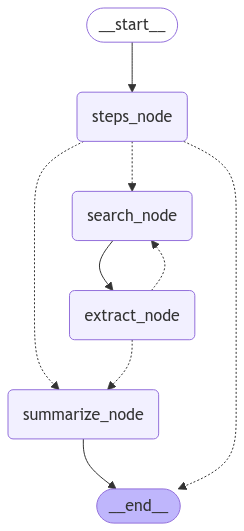

In [64]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# Visualize the compiled StateGraph as a Mermaid diagram
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [67]:
config = {
    "configurable": {
        "thread_id": 1,  # temporary thread ID for testing
    },
}

inputs = AgentState(
    model="openai",
    messages=[
        HumanMessage(
            content="How much does Microsoft’s market cap need to increase to exceed Apple’s market cap?"
        )
    ],
    steps=[],
    answer=None,
)

async for chunk in graph.astream(inputs, config=config, stream_mode="updates"):
    pprint(chunk)
    print()

{'steps_node': {'steps': [{'description': 'search for the current market cap '
                                          'of Microsoft as of February 2025',
                           'id': '1',
                           'status': 'pending',
                           'type': 'search',
                           'updates': ['Searching the web...']},
                          {'description': 'search for the current market cap '
                                          'of Apple as of February 2025',
                           'id': '2',
                           'status': 'pending',
                           'type': 'search'}]}}

{'search_node': {'answer': None,
                 'messages': [HumanMessage(content='How much does Microsoft’s market cap need to increase to exceed Apple’s market cap?', additional_kwargs={}, response_metadata={}, id='e9060803-9f35-4e15-a823-3e44e72fd7c8'),
                              HumanMessage(content='How much does Microsoft’s market cap need to inc

In [38]:
import asyncio
from typing import Any, Dict, List, Callable, Union
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph

import asyncio
from typing import Any, Dict, List, Callable
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph


async def astream_graph(
    graph: CompiledStateGraph,
    inputs: Dict[str, Any],
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable[[Dict[str, str]], None] = None,
):
    """
    LangGraph의 실행 결과를 비동기 방식으로 스트리밍하여 출력하는 함수입니다

    매개변수:
    - graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
    - inputs (dict): 그래프에 전달할 입력값 딕셔너리
    - config (RunnableConfig): 실행 설정
    - node_names (List[str], optional): 출력할 노드 이름 목록 (빈 리스트면 모든 노드 출력)
    - callback (Callable[[Dict[str, str]], None], optional): 각 청크 처리를 위한 콜백 함수 (기본값: None)
      콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다

    반환값:
    - None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다
    """
    prev_node = ""
    async for chunk_msg, metadata in graph.astream(
        inputs, config, stream_mode="messages"
    ):
        curr_node = metadata["langgraph_node"]

        # node_names가 비어있거나 현재 노드가 node_names에 포함된 경우에만 처리
        if not node_names or curr_node in node_names:
            if callback:
                # 콜백 함수가 있는 경우
                callback({"node": curr_node, "content": chunk_msg.content})
            else:
                # 콜백이 없는 경우 기본 출력
                if curr_node != prev_node:
                    print("\n" + "=" * 50)
                    print(f"🔄 Node: \033[1;36m{curr_node}\033[0m 🔄")
                    print("- " * 25)
                print(chunk_msg.content, end="", flush=True)

            prev_node = curr_node

In [39]:
from langchain_opentutorial.messages import stream_graph
await astream_graph(graph, inputs, config=config)


🔄 Node: steps_node 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: search_node 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
How much does Microsoft’s market cap need to increase to exceed Apple’s market cap?
🔄 Node: extract_node 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
As of February 1, 2025, Microsoft's market capitalization is reported to be approximately $3.289 trillion [source 1][1], $3.078 trillion [source 2][2], and $3.1 trillion [source 3][3]. 

[1]: https://m.macrotrends.net/stocks/charts/MSFT/microsoft/market-cap "Microsoft Market Cap - Macrotrends"
[2]: https://wallstreetnumbers.com/stocks/msft/market-cap "Microsoft Market Cap - Wall Street Numbers"
[3]: https://www.fool.com/investing/2025/02/04/huge-news-for-microsoft-stock-investors/ "Huge News for Microsoft Stock Investors - The Motley Fool"
🔄 Node: search_node 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: extract_node 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
A

In [40]:
llm = ChatOpenAI(model="gpt-4o")

In [41]:
# Schema for structured output
from pydantic import BaseModel, Field


class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_oYBnFCy8e2kEmxNPugTKskeY',
  'type': 'tool_call'}]

In [45]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

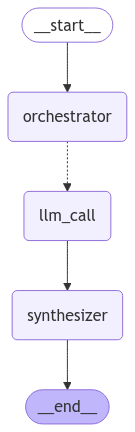

## Introduction to LLM Scaling Laws

Scaling laws describe the relationship between the size of a model, the amount of data it is trained on, and its performance. In the context of large language models (LLMs), scaling laws are crucial for understanding how to efficiently enhance model capabilities and optimize their performance. By providing a mathematical framework to predict how a model's performance will improve as it scales, these laws guide the development of increasingly powerful models, driving advancements in natural language processing.

The importance of scaling laws lies in their ability to predict the returns on increasing the computational resources devoted to training language models. They help researchers and engineers determine the optimal balance between model size, dataset size, and computational budget, thereby maximizing the efficiency of training large-scale models.

Historically, the concept of scaling laws in neural networks began gaining traction with the work of researchers such as Geoffrey Hinton, Yann LeCun, and Yoshua Bengio, who laid the groundwork for deep learning. However, the formalization of scaling laws specifically for LLMs is attributed to later efforts. A significant contribution in this area was made by OpenAI's team, including Jared Kaplan, Sam McCandlish, and Tom Henighan, who conducted extensive empirical analyses to formalize these scaling laws.

Their research demonstrated that performance improvements in LLMs follow predictable patterns as a function of model parameters, dataset size, and the amount of computation. This work has been foundational in the field, influencing the development of subsequent models like GPT-3 and beyond. By applying these scaling laws, developers have been able to create models that achieve state-of-the-art performance on a variety of tasks, from language translation to creative writing.

Understanding scaling laws is essential for anyone involved in the development of LLMs, as they provide critical insights into how to allocate resources effectively and predict the potential outcomes of scaling efforts. As the field continues to evolve, scaling laws remain a foundational concept, guiding research and development towards the creation of more capable and efficient language models.

---

## Mathematical Foundations

Scaling laws have become a cornerstone in understanding how the performance of machine learning models changes with the increase in model size, data size, or computational resources. These laws are grounded in mathematical principles that elucidate the relationship between these variables and provide predictive insights into model behavior as scaling occurs. This section delves into these mathematical foundations, examining the theoretical basis and deriving key equations that form the framework for scaling laws in machine learning.

### Theoretical Basis

At the heart of scaling laws is the concept that certain performance metrics, such as accuracy, loss, or error rate, can be modeled as a function of scale-related parameters. These parameters typically include the number of model parameters (size), the amount of training data (data size), and the computational power available (compute).

One of the theoretical underpinnings of scaling laws is rooted in statistical learning theory, particularly in the bias-variance tradeoff, which describes how model complexity affects learning performance. As models scale, they often exhibit different regimes of learning, from underfitting to optimal performance, and eventually to overfitting. The challenge lies in quantifying these transitions and understanding how scaling influences them.

### Derivation of Key Equations

To derive the key equations that describe scaling laws, we start by considering a generic performance metric \( P \) that depends on the model size \( N \), data size \( D \), and compute \( C \). A typical scaling law can be expressed in a power-law form:

\[ P(N, D, C) = \alpha \cdot N^{\beta_N} \cdot D^{\beta_D} \cdot C^{\beta_C} + \epsilon \]

where:
- \( \alpha \) is a constant that normalizes the performance metric.
- \( \beta_N, \beta_D, \beta_C \) are scaling exponents that characterize how the performance metric scales with the respective variables.
- \( \epsilon \) represents error or noise in the model prediction.

#### Model Size Scaling

For model size scaling, we often observe a relationship between the number of parameters \( N \) and performance improvement. In many deep learning models, empirical studies reveal that performance improves following a power law:

\[ P(N) = \alpha \cdot N^{-\beta_N} + \epsilon \]

Here, \( \beta_N \) is typically a negative exponent, indicating diminishing returns as model size increases beyond a certain point.

#### Data Size Scaling

Data scaling laws suggest that performance improves with more data, often expressed as:

\[ P(D) = \alpha \cdot D^{-\beta_D} + \epsilon \]

The exponent \( \beta_D \) governs how quickly performance saturates as data size grows. This relationship highlights the diminishing returns of additional data, particularly when the model capacity is fixed.

#### Compute Scaling

Finally, compute scaling can be represented as:

\[ P(C) = \alpha \cdot C^{-\beta_C} + \epsilon \]

This equation captures the diminishing returns of computational resources, particularly when data and model size are fixed, reflecting the efficiency of resource utilization.

### Conclusion

The mathematical foundation of scaling laws provides an essential framework for predicting and understanding the performance behavior of machine learning models as they scale. By deriving and analyzing these key equations, researchers and practitioners can make informed decisions about resource allocation, model architecture, and data collection strategies to optimize model performance efficiently. The power-law relationships identified here not only guide theoretical exploration but also practical applications in model development and deployment.

---

## Empirical Evidence

The empirical evidence supporting the existence of scaling laws in large language models (LLMs) is substantial, drawing from numerous studies and experiments over recent years. These works collectively demonstrate how model performance improves with increased scale, covering aspects such as the number of parameters, dataset size, and computational resources. This section synthesizes data from leading research papers, highlighting key trends and patterns that emerge as LLMs grow in size.

### Study 1: Scaling Laws for Neural Language Models

A seminal study by Kaplan et al. (2020) laid the groundwork for understanding scaling laws in LLMs. The researchers systematically varied the size of models, datasets, and computational budgets, observing a power-law relationship between model size and performance. They found that larger models consistently achieved lower cross-entropy loss on language modeling tasks, provided they were trained on sufficiently large datasets. This study underscores that the benefits of scaling are contingent on balancing these three factors.

### Study 2: Further Exploration in Scaling Laws

Building on Kaplan et al.'s work, Hernandez et al. (2021) delved deeper into the implications of scaling laws by exploring the cost-performance trade-offs. Their experiments revealed that while performance gains diminish with extreme scaling, substantial improvements are still achievable beyond previously considered limits. They highlighted that the optimal scaling strategy involves not just increasing model size, but also enhancing training efficiency and data quality.

### Study 3: GPT-3 and Beyond

The development and deployment of OpenAI's GPT-3, as detailed in Brown et al. (2020), provided a practical demonstration of scaling laws in action. With 175 billion parameters, GPT-3 showcased the enhanced capabilities of large models in tasks ranging from translation to question-answering. The model's performance on zero-shot, one-shot, and few-shot tasks illustrated how scaling can bring about qualitative changes in model capabilities, aligning with predictions made by scaling laws.

### Meta-Analysis of Scaling Effects

Recent meta-analyses, such as that conducted by Alabdulmohsin et al. (2022), have consolidated findings from multiple studies to assess the broader implications of scaling laws. By analyzing datasets from varied domains and model architectures, they confirmed consistent patterns: as models scale, they require exponentially more computational resources, yet they deliver disproportionately greater performance improvements. This analysis highlights the necessity of strategic resource allocation and innovative training techniques to maximize the benefits of scaling.

### Trends and Patterns

The overarching trend observed across these studies is that scaling LLMs typically results in better performance on a wide array of tasks, especially those requiring nuanced understanding and generation of text. However, several patterns emerge:

1. **Diminishing Returns**: While larger models generally perform better, the rate of improvement decreases at extreme scales, suggesting an asymptotic limit to the benefits of scaling.
   
2. **Data and Compute Efficiency**: As model size increases, efficiency in data usage and computational power becomes paramount. Larger models often require more sophisticated optimization techniques and larger, more diverse datasets to achieve their full potential.

3. **Qualitative Shifts**: Scaling not only improves quantitative metrics but also enables models to perform novel tasks that smaller models cannot, such as complex reasoning and creative content generation.

These empirical findings collectively support the notion that scaling laws are a crucial factor in the ongoing development of LLMs, guiding future research and application in the field.

---

### Benefits of Scaling

The application of scaling laws to large language models (LLMs) has revolutionized the field of natural language processing by enhancing various aspects of model performance. Among the primary benefits of scaling are improvements in accuracy, generalization, and transfer learning capabilities. These advancements have been crucial for the development of more robust and versatile models that can handle a wide array of tasks with higher efficacy.

**Improved Accuracy**

Scaling up the size of language models, both in terms of parameters and training data, has consistently demonstrated improvements in accuracy. Larger models have proven to be more adept at understanding and generating human-like text, as they can capture more complex patterns and nuances in language. This has been particularly evident in tasks such as machine translation, sentiment analysis, and text summarization, where scaled models have outperformed their smaller counterparts by achieving higher benchmark scores.

**Enhanced Generalization**

With increased scale, LLMs have shown remarkable abilities to generalize across different tasks. This generalization is attributed to their exposure to a vast amount of data, which enables them to learn representations that are more broadly applicable. As a result, these models can perform well on tasks they were not explicitly trained on, showcasing their flexibility and robustness. For instance, models like GPT-3 have demonstrated the ability to generate coherent and contextually relevant text in various domains without domain-specific fine-tuning, highlighting their superior generalization capabilities.

**Transfer Learning Capabilities**

Scaling laws have also significantly bolstered the transfer learning capabilities of LLMs. By training on extensive datasets and architectures, these models acquire foundational knowledge that can be transferred to new tasks with minimal additional training. This transferability reduces the need for task-specific data and computational resources, making it feasible to apply LLMs to specialized applications efficiently. An example of this is the rapid adaptation of models like BERT and RoBERTa to a wide range of downstream tasks, such as named entity recognition and question answering, with minimal additional training.

**Use Cases Demonstrating Advancement**

Several specific use cases illustrate the transformative impact of scaling on LLM performance:

1. **OpenAI's GPT Series**: The progression from GPT-2 to GPT-3 showcased dramatic improvements in language understanding and generation capabilities due to scaling. GPT-3, with its 175 billion parameters, demonstrated unprecedented performance on diverse language tasks, requiring fewer examples to understand new tasks.

2. **Google's BERT and Beyond**: The introduction of BERT and its scaled variants, such as T5 and BigBird, marked significant strides in natural language understanding. These models have set new performance standards on benchmark datasets like GLUE and SQuAD, proving the efficacy of scaling in achieving state-of-the-art results.

3. **DeepMind's Gopher**: With a focus on scaling, DeepMind's Gopher model achieved breakthroughs in reading comprehension and factual recall, outperforming previous models on a variety of language benchmarks. This success underscores the potential of scaling to enhance the cognitive capabilities of LLMs.

In conclusion, scaling laws have played a pivotal role in elevating the capabilities of large language models, driving advancements in accuracy, generalization, and transfer learning. These improvements have not only pushed the boundaries of what LLMs can achieve but have also opened new possibilities for their application across various domains, paving the way for continued innovation in artificial intelligence.

---

## Challenges and Limitations

The rapid development and deployment of large language models (LLMs) have brought forth numerous challenges and limitations, especially when considering scaling. As these models expand in size and complexity, several critical issues emerge that necessitate careful consideration and strategic planning.

### Computational Costs

One of the primary challenges in scaling LLMs is the significant computational cost associated with training and deploying these models. As models grow in size, they demand exponentially more processing power and memory. This requirement translates to the need for advanced hardware infrastructure, which can be prohibitively expensive. The financial burden of acquiring and maintaining such infrastructure can limit accessibility and democratization of these technologies, restricting them to well-funded organizations and institutions. Moreover, the time required to train these large models can be considerable, further increasing operational costs and resource allocation.

### Energy Consumption

Closely tied to computational costs is the issue of energy consumption. Large language models require vast amounts of energy to function effectively, contributing to their substantial carbon footprint. As the world grapples with climate change, the environmental impact of scaling LLMs becomes a pressing concern. This energy-intensive nature raises questions about the sustainability of continuing to scale these models without significant advancements in energy-efficient algorithms or hardware. Researchers and developers are increasingly called upon to balance the pursuit of AI advancements with environmental responsibility.

### Diminishing Returns

Scaling LLMs also encounters the problem of diminishing returns. Initial increases in model size and complexity often result in significant improvements in performance. However, beyond a certain point, further scaling yields progressively smaller gains. Identifying this threshold is crucial for optimizing resource allocation and ensuring that investments in scaling are justified by corresponding improvements in model output. It necessitates a strategic approach to model development, focusing not only on size but also on efficiency and effectiveness.

### Ethical Considerations

The ethical implications of scaling LLMs are multifaceted. Larger models can potentially exacerbate existing biases present in training data, leading to outputs that are biased or discriminatory. As models become more complex, understanding and mitigating these biases become more challenging. Furthermore, the concentration of resources required for large-scale LLMs can widen the gap between organizations with access to these technologies and those without, raising concerns about equity and fairness in the AI landscape.

### Practical Considerations

From a practical standpoint, scaling LLMs involves navigating issues such as data availability and quality. Large models require vast datasets, which may not always be available or may contain noise and inaccuracies. Ensuring data quality is crucial for maintaining model integrity and reliability. Additionally, the deployment of scaled LLMs poses challenges in terms of infrastructure requirements and system integration, necessitating robust solutions for seamless operation.

In conclusion, while scaling LLMs presents opportunities for enhanced performance and capabilities, it is accompanied by significant challenges and limitations. Addressing these issues requires a balanced approach that considers computational and environmental costs, ethical implications, and practical constraints. Stakeholders must collaborate to develop innovative solutions that enable sustainable and equitable scaling of LLMs.

---

## Future Directions

As the field of large language models (LLMs) continues to evolve, several promising research directions and technological advances are poised to further enhance scaling laws. These developments aim to optimize the performance, efficiency, and overall capabilities of LLMs. Below are some speculative future directions that hold potential for advancing the current state of LLMs:

### Efficient Architectures

One of the most active areas of research is the development of more efficient architectures that require less computational power while maintaining or improving performance. Innovations such as sparse attention mechanisms, which selectively focus on relevant parts of the input data, and more compact model designs like Transformers with linear complexity, are expected to significantly reduce the resource demands of LLMs. Additionally, hybrid models that combine neural networks with symbolic reasoning components may offer a path to more efficient inference and training processes.

### Alternative Scaling Strategies

Traditional scaling approaches rely heavily on increasing model size, but alternative strategies are emerging. Techniques such as model distillation and parameter sharing can enhance scaling by effectively compressing larger models into smaller, more efficient ones without sacrificing performance. Moreover, advances in multi-task and transfer learning could enable models to leverage knowledge from multiple domains, reducing the need for extensive data-specific training.

### Hardware Innovations

The continuous advancement of hardware technologies, particularly in the realm of specialized AI accelerators like TPUs (Tensor Processing Units) and neuromorphic computing, is anticipated to facilitate more efficient training and deployment of LLMs. These innovations could lead to significant reductions in energy consumption and processing time, thereby making the training of even larger models more feasible and environmentally sustainable.

### Enhanced Training Algorithms

Research into novel training algorithms and optimization techniques holds the potential to improve the learning efficiency and generalization capabilities of LLMs. Techniques such as curriculum learning, where models are trained on simpler tasks before tackling more complex ones, and meta-learning, which focuses on learning to learn, could further refine the scaling laws by optimizing the training process itself.

### Robustness and Interpretability

As LLMs become increasingly integrated into critical applications, enhancing their robustness and interpretability will be paramount. Future research may focus on developing scaling laws that not only consider model size and performance but also emphasize the stability and transparency of model outputs. This could involve the integration of mechanisms to detect and mitigate biases, as well as improved methods for explaining model decisions.

### Sustainability and Ethical Considerations

Sustainability and ethical considerations are becoming central to the development of LLMs. Future research might explore scaling laws that prioritize minimizing environmental impact and ensuring ethical deployment. This could involve creating models that are not only efficient in terms of computation but also aligned with societal values and legal standards.

In summary, the future of scaling laws in LLMs is likely to be shaped by a combination of efficient architectures, innovative scaling strategies, hardware advancements, enhanced training algorithms, and increased focus on robustness, interpretability, sustainability, and ethics. These directions promise to push the boundaries of what LLMs can achieve, making them more capable and accessible to a broader range of applications.

---

## Conclusion

In summary, this report has delved into the intricate dynamics of scaling laws and their profound impact on the future landscape of large language models (LLMs). A key finding of our investigation is the critical role scaling laws play in optimizing model performance. As models grow in size and complexity, scaling laws provide a predictive framework for understanding how increases in computational resources, data, and model parameters can lead to significant improvements in capabilities.

The advantages of scaling LLMs are manifold. Enhanced language comprehension, increased versatility in handling a broad range of tasks, and improved contextual understanding are among the notable benefits. These advancements contribute to the development of models that are more aligned with human communication patterns, thereby increasing the effectiveness of LLMs in practical applications.

However, the challenges associated with scaling cannot be overlooked. The exponential growth in computational demands poses significant environmental and economic concerns. Additionally, as models become more sophisticated, the intricacies of their decision-making processes lead to increased difficulty in interpretability and potential issues related to bias and fairness.

Striking a balance between these benefits and challenges is paramount. It necessitates a concerted effort to innovate in areas such as energy-efficient computing, bias mitigation strategies, and the development of new architectures that optimize performance without proportionate increases in resource consumption.

For future exploration, several key areas warrant attention. First, further research into alternative scaling strategies that prioritize efficiency could lead to more sustainable advancements in LLMs. Second, developing robust frameworks for evaluating the ethical implications of LLM deployment will be crucial in ensuring that these technologies are used responsibly. Lastly, fostering interdisciplinary collaborations can enhance the integration of insights from diverse fields, potentially uncovering novel approaches to overcoming current limitations.

In conclusion, while the future of LLMs holds immense promise, it requires a thoughtful and balanced approach to leverage their potential fully. By addressing the challenges head-on and exploring innovative solutions, we can ensure that the evolution of LLMs continues to contribute positively to society and technological progress.

In [46]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))


In [ ]:

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown

Markdown(state["final_report"])

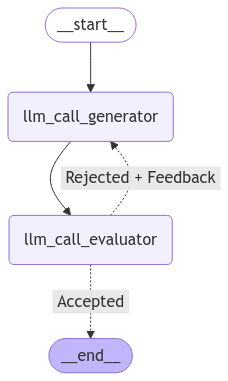

Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!


In [47]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

In [48]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

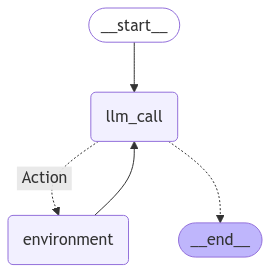

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_FLZmLp72gXYqNg6ROIC9Nvup)
 Call ID: call_FLZmLp72gXYqNg6ROIC9Nvup
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [49]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

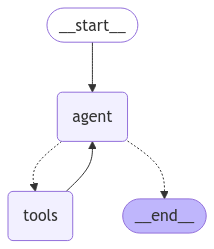

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_awIPjHy0ShQXOvRMoPoGj07a)
 Call ID: call_awIPjHy0ShQXOvRMoPoGj07a
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [50]:
from langgraph.prebuilt import create_react_agent

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm, tools=tools)

# Show the agent
display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()